<img align="right" src="../additional_data/banner.png" style="width:1100px;">

# Forest inventory

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: Users should review the [mosaic-](mosaic.ipynb), [export_geotiff-](export_geotiff.ipynb) notebook for more information about the basic steps for any given temporal and spatial combination. Further, knowledge about working with SQL can be useful. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

### Background

Forests are complex biomes. Anaylzing them is an important task to enhance the understanding, also in the context of the current global change. Forests have an important role, e.g. econmical or as carbon sink, which can also be conenected to monetary aspects (CO2 certificates). Furhter societal benefits are in the context of healthcare, e.g. allergies or considering upcoming zoonoses like the Covid-19 pandemic as well as forests role in recreation.


This example tries to demonstrate a potential workflow from loading and processing (cloud removal, median-mosaicing, index calculation) satellite raster-data togehter with additional on-demand vector-data nd export them as cloud-optimized-geotiff for individual processing, e.g. in a local GIS.

### Preliminary steps

In [1]:
# Supress Warning
import warnings
warnings.filterwarnings('ignore')
# Import (geo)pandas package with shortcut (g)pd
import pandas as pd
import geopandas as gpd
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'forest_inventory', config = '/home/datacube/.datacube.conf')
import sys

### Loading your area of interest as sahepfile (here: different conservation zones in Rhoen Highlands)

In [2]:
#rhoen = gpd.read_file('MDPI/ONE/biosphaerenreservate_epsg25832_shp.shp')

In [3]:
rhoen = gpd.read_file('../additional_data/rhoen.geojson')

### Alternative load data from PostGIS (spatial PostgreSQL-extension)

In [4]:
# database API
import psycopg2
# PostGIS connection credentials
user = 'dc_user'
password = 'localuser1234'
host = '127.0.0.1'
port = '5432'
database = 'datacube'

In [5]:
# 1. open connection first, 2. write data, 3. close afterwards
connection = psycopg2.connect(database=database, user=user, password=password, host=host)

# Forest inventory data downloaded: 'GFs_ReinbestandGattung_mitSp_PolyVar'
# see https://bwi.info/

# sql statement looking for 'geom, tnr, pquerus (percent share oak), pfagus (percent share beech), pfraxinus (percent share ash), 
# pabies (percent share fir)  ppicea (percent share spruce), ppinus (percetn share pine)'
forest_inventory = gpd.GeoDataFrame.from_postgis("SELECT * FROM etrs89_bwi_2012p;", connection)
attributes =pd.read_sql_query("SELECT  column_name FROM information_schema.columns WHERE table_name = 'etrs89_bwi_2012p';",con=connection)
forest = gpd.GeoDataFrame.from_postgis("SELECT * FROM etrs89_bwi_2012p WHERE tnr > 16617 AND tnr < 16623 ;", connection)
tr_nr_16086 = gpd.GeoDataFrame.from_postgis("SELECT geom, tnr, pquerus, pfagus, pfraxinus, pabies, ppicea, ppinus FROM etrs89_bwi_2012p WHERE tnr = 16086 ;", connection)


connection.close()

attributes = attributes.column_name
attributes = list(attributes)
attributes.remove('geom')

forest_inventory_wgs = forest_inventory.to_crs('EPSG:4326')
forest_wgs = forest.to_crs('EPSG:4326')
#forest_inventory

In [6]:
import folium

# define polygon style
style = {'fillColor': '#ffffffff', 'color': '#000000'}

# open map 'm' with defined center and zomm level
m = folium.Map([50, 10.5], zoom_start=12)#, tiles='Stamen Terrain')

# load esris satellite map
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# add geojson
#folium.GeoJson(forest_inventory_wgs, style_function=lambda x: style, name="bwi",
 #                            tooltip=folium.features.GeoJsonTooltip(fields=attributes, localize=True)).add_to(m)
#folium.GeoJson(rhoen, name="Rhoen").add_to(m)

folium.GeoJson(tr_nr_16086, name="16086", tooltip=folium.features.GeoJsonTooltip(fields=["ppicea","pfagus","tnr"], localize=True)).add_to(m)


# load openstreet map
folium.TileLayer('openstreetmap').add_to(m)

# load terrain map
folium.TileLayer('Stamen Terrain').add_to(m)

# add lat/lon popup after click on maps
#folium.LatLngPopup().add_to(m)

#
#folium.ClickForMarker().add_to(m)
# open layer control in upper right corner of the map
folium.LayerControl().add_to(m)
m

### Another alternative, create your area of interest

Here we load a map visualisation package called 'folium' and a plugin for drawing:

In [7]:
# needed extra packages
import folium
from folium.plugins import Draw

In [8]:
# define polygon style
style = {'fillColor': '#ffffffff', 'color': '#000000'}

# open map 'm' with defined center and zomm level
m = folium.Map([50.22, 9.84], zoom_start=12)#, tiles='Stamen Terrain')

# load esris satellite map
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# add geojson
folium.GeoJson(forest_wgs.to_json(), style_function=lambda x: style, name="rhoen").add_to(m)

# load openstreet map
folium.TileLayer('openstreetmap').add_to(m)

# load terrain map
folium.TileLayer('Stamen Terrain').add_to(m)

# add lat/lon popup after click on maps
folium.LatLngPopup().add_to(m)

#
#folium.ClickForMarker().add_to(m)
# open layer control in upper right corner of the map
folium.LayerControl().add_to(m)
# draw plugin
Draw(
    export=True,
    filename='my_data.geojson',
    position='topleft',
    draw_options={'polyline': {'allowIntersection': False}},
    edit_options={'poly': {'allowIntersection': False}}
).add_to(m)
m

In [9]:
[9.804654,50.202018],[9.804654,50.229898],[9.853422,50.229898],[9.853422,50.202018],[9.804654,50.202018]]]}}

SyntaxError: unmatched ']' (<ipython-input-9-89af5ebf358e>, line 1)

In [9]:
from pyproj import CRS
from shapely.geometry import Polygon, shape
# copy and paste coordinates
y_min = 50.201579
y_max = 50.234945
x_min = 9.803624
x_max = 9.865099
# sort them to latitude and longitude 
lat_point_list = [y_min, y_max, y_max, y_min, y_min]
lon_point_list = [x_min, x_min, x_max, x_max, x_min]
# build a WGS84 polygon for dispalying on webmap
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = CRS('EPSG:4326')
rhoen_deg = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
# and using regional UTM projection
rhoen_utm = rhoen_deg.to_crs('EPSG:25832')
# and extract regional UTM coordintes
minx = rhoen_utm.bounds.iloc[0,0]
maxx = rhoen_utm.bounds.iloc[0,2]
miny = rhoen_utm.bounds.iloc[0,1]
maxy = rhoen_utm.bounds.iloc[0,3]

## Load Sentinel-2 data from the datacube

Here we are loading a timeseries of `Sentinel-2` satellite images through the datacube API.(official coordinate system ['EPSG:25832'](https://www.ldbv.bayern.de/file/pdf/12867/Faltblatt_UTM-Umstellung.pdf))

In [7]:
# writing query extents from inventory tract
minx = tr_nr_16086.bounds.iloc[0,0]
maxx = tr_nr_16086.bounds.iloc[0,2]
miny = tr_nr_16086.bounds.iloc[0,1]
maxy = tr_nr_16086.bounds.iloc[0,3]

In [8]:
# Create query variables
product = 's2_l2a_bavaria'
x_min = minx
x_max = maxx
y_min = miny
y_max = maxy
cosy = 'EPSG:25832'
time_extent = ('2015-01-01', '2020-12-31')

Loading may take a few minutes

In [15]:
# Lazy load data using dask-chunks
dataset = dc.load(product=product,
                  y= (y_min, y_max),
                  x=(x_min, x_max),
                  crs=cosy,
                  time=time_extent,
                  dask_chunks={"time": 1, "x": 500, "y": 500})

Delete no data scenes

In [11]:
mean = dataset.mean(dim=['x','y'])
ls = mean.time.where(mean.red != 0, drop=True)
dataset=dataset.sel(time=pd.to_datetime(ls.values.tolist()))

In [12]:
# dsplay an overview of the data
dataset

<xarray.Dataset>
Dimensions:          (time: 935, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2015-07-30T10:30:16 ... 2020-12-30...
  * y                (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x                (x) float64 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    blue             (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    green            (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    red              (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    red_edge1        (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    red_edge2        (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    red_edge3        (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    nir              (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    narrow_nir       (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    water_vapour     (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    swir1            (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    swir2            (time, y, x) int16 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
    scl              (time, y, x) uint8 dask.array<chunksize=(5, 227, 227), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

### Plot an rgb image to confirm we have data

The 'time' dimension above (68) shows the number of observations and is also the range that can be choosen, considering that Python starst counting with `0`, so we can choose between 0 and 67.

In [17]:
sys.path.append('/datacube/data_cube_notebooks/datacube/Scripts')
from DEAPlotting import rgb

rgb(dataset, index=[50], percentile_stretch=(0.11, 0.99), size=8)

ValueError: dimension variable on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(variable: -1)``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

### Add a new 'measurements', i.e. measurment ratios, to the data

You can find a big overview of indices here: <br> https://www.indexdatabase.de

Here we use a simple ratio (SR) and a normalized difference vegetation index (NDVI) and add them to the dataset.

In [18]:
SR = (dataset.narrow_nir / dataset.red)
NDVI = (dataset.narrow_nir - dataset.red)/(dataset.narrow_nir + dataset.red)

dataset['ndvi'] = NDVI
dataset['sr'] = SR

We can control if there are new entries in 'dataset'

In [19]:
dataset

<xarray.Dataset>
Dimensions:          (time: 1249, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2015-07-04T10:13:37 ... 2020-12-30...
  * y                (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x                (x) float64 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    blue             (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    green            (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red              (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge1        (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge2        (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge3        (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    nir              (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    narrow_nir       (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    water_vapour     (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    swir1            (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    swir2            (time, y, x) int16 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    scl              (time, y, x) uint8 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    ndvi             (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    sr               (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Masking out clouds
Loading needed functions first

In [20]:
#from s2fn import s2_unpack_scl
import xarray as xr
from xarray.ufuncs import logical_and as xr_and
from xarray.ufuncs import logical_or  as xr_or
import numpy as np
import pandas as pd
from functools import partial 

def s2_scl_clean_mask(dataset, cover_types=['vegetation', 'vegetation']):# here, masking everything instead of scl 'vegetation'
    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    for i, cover_type in enumerate(cover_types):
        cover_type_clean_mask = s2_unpack_scl(dataset.scl, cover_type)
        clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    return clean_mask

def unpack_s2bits(s2_scl_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, s2_scl_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_scl(data_array , cover_type):
    s2_scl_endcoding = dict(no_data                       =[0],
                                saturated_or_defective        =[1],
                                dark_area_pixels              =[2],
                                cloud_shadows                 =[3],
                                vegetation                    =[4],
                                not_vegetated                 =[5],
                                water                         =[6],
                                unclassified                  =[7],
                                cloud_medium_probability      =[8],
                                cloud_high_probability        =[9],
                                thin_cirrus                   =[10],
                                snow                          =[11],
                                cloud                         =[3,8,9,10],
                                cloud_free                    =[4,5,6]
                               )
    return unpack_s2bits(s2_scl_endcoding, data_array, cover_type)

def s2_clean_mask(ds, bands):
    masks = [s2_unpack_scl(ds, band) for band in bands]
    return np.logical_or(*masks).values

def s2_cct(dataset):
    times  = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.sel(time = t).scl, times))
    clean_mask_list = list(map(partial(s2_clean_mask, bands = ['vegetation','vegetation']), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1] * 0.01), clean_mask_list))

    data = {"Acquisition time": times,
            "Vegetation [%]": percentage_list,
            "Vegetation pixel [n]": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["Acquisition time", "Vegetation [%]", "Vegetation pixel [n]"])



### Make a vegetation overview
Write new variable 'cloudtable' using the defined function s2_cct

In [21]:
cloudtable = s2_cct(dataset)
# print the table
#cloudtable

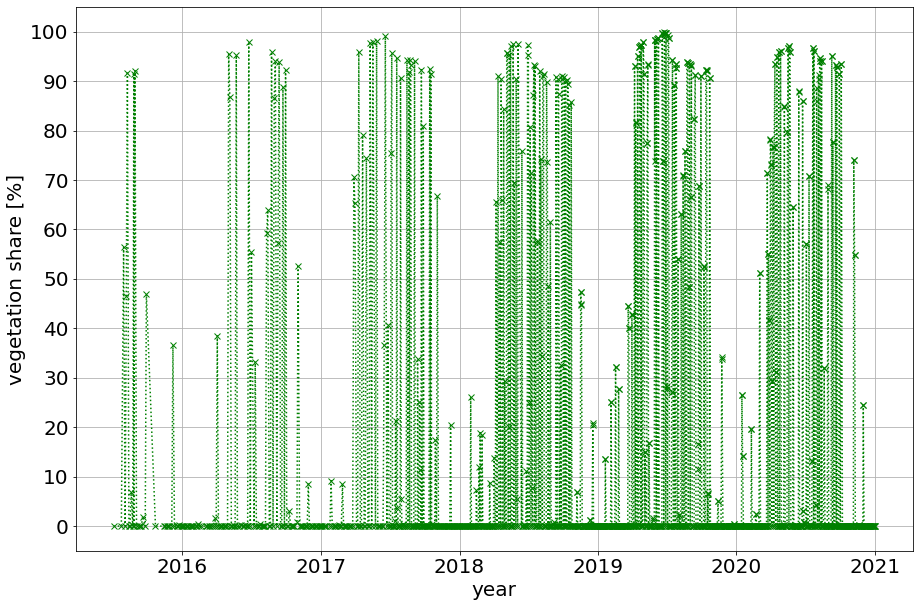

In [51]:
import matplotlib.pyplot as plt
cct = cloudtable

plt.figure(figsize = (15,10))
plt.plot(cct["Acquisition time"], cct["Vegetation [%]"], 'gx:', markersize=6)
#x_ticks = np.arange(20000, 20200, 50)
plt.xticks(rotation=0,size=20,)
plt.yticks(list(range(0,105,10)),size=20)
plt.ylabel('vegetation share [%]', size=20)
plt.xlabel('year', size=20)
plt.grid(True)

plt.savefig('tract16086.png')
plt.show()

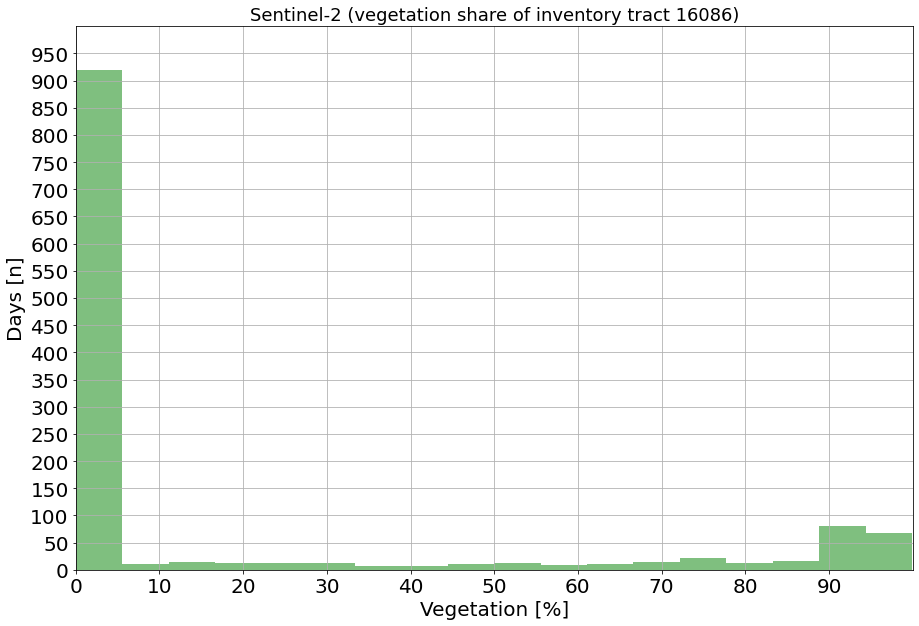

In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.figure(figsize = (15,10))
#plt.scatter(cloud_table["times"].values, cloud_table["clean_percentage"].values)
plt.hist(cct["Vegetation [%]"], 18, facecolor='g', alpha=.5)
plt.title('Sentinel-2 (vegetation share of inventory tract 16086)', size='18')# ( '+ 
#          np.datetime_as_string(dataset.time[0].values).split('T')[0] + " to " +
 #         np.datetime_as_string(dataset.time[-1].values).split('T')[0] + ")", 
  #        size='18')

plt.xlabel('Vegetation [%]', size=20)
plt.ylabel('Days [n]', size=20)
plt.yticks(list(range(0,1000,50)),size='20')
plt.xticks(list(range(0,100,10)),size='20')
plt.axis([0,100, 0, 1000])
plt.grid(True)
plt.savefig('cloud_tract16086.png')
plt.show()

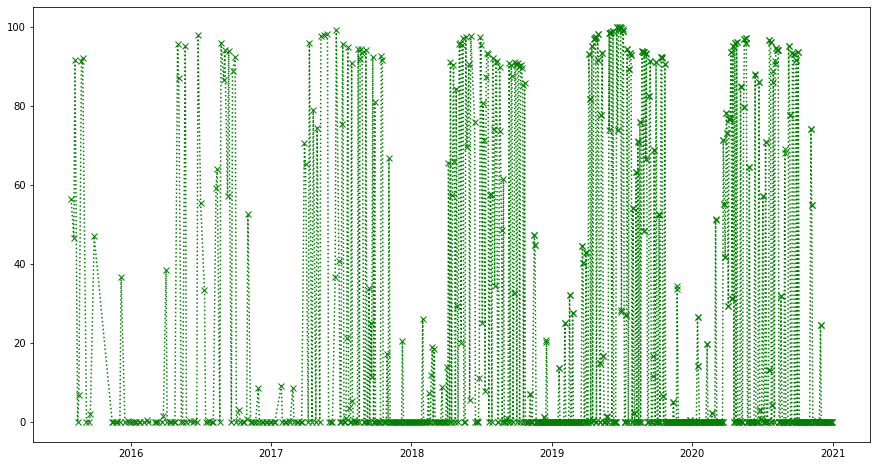

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.plot(cloudtable["Acquisition time"].values, cloudtable["Vegetation [%]"].values, 'gx:', markersize=6)
plt.show()

### Mask data

Use again the previous defined functions to write the 'cloud_mask'

In [68]:
cloud_mask = s2_scl_clean_mask(dataset)

And use the mask to write 'cleaned_dataset'. The 'cleaned_dataset' here only carries pixels classified as vegetation.

In [69]:
cleaned_dataset = dataset.where(cloud_mask)

In [70]:
cleaned_dataset

<xarray.Dataset>
Dimensions:          (time: 1249, x: 227, y: 227)
Coordinates:
  * time             (time) datetime64[ns] 2015-07-04T10:13:37 ... 2020-12-30...
  * y                (y) float64 5.546e+06 5.546e+06 ... 5.543e+06 5.543e+06
  * x                (x) float64 6.03e+05 6.03e+05 ... 6.052e+05 6.052e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    blue             (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    green            (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red              (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge1        (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge2        (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    red_edge3        (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    nir              (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    narrow_nir       (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    water_vapour     (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    swir1            (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    swir2            (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    scl              (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    ndvi             (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
    sr               (time, y, x) float64 dask.array<chunksize=(1, 227, 227), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Generating median mosaics
### Annual, using 'cleaned_dataset'

This method masks clouds from imagery using the median of the cloud-free pixels in the time series.

In [71]:
sys.path.append('/datacube/data_cube_notebooks/sebastian_foertsch/utils/')

In [72]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

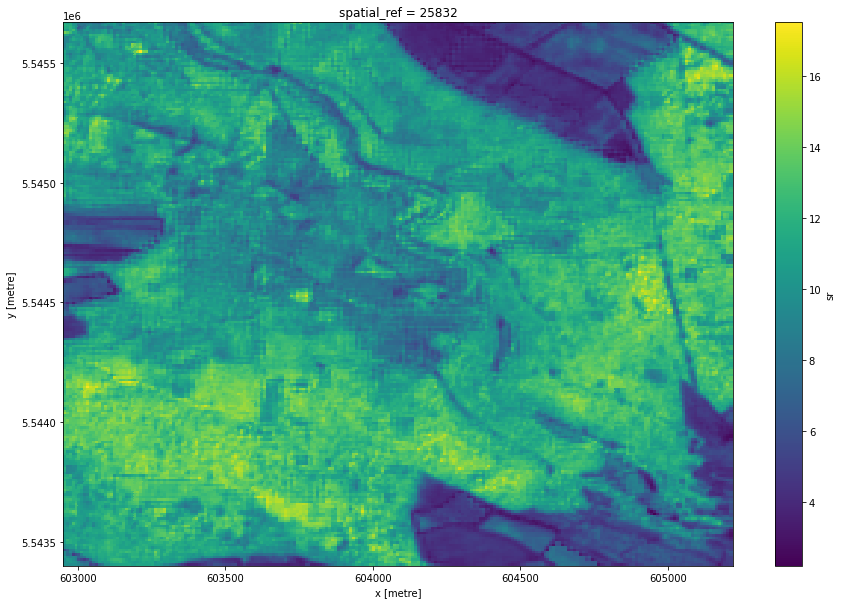

In [73]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.sr.plot(size=10) #
# ...


In [74]:
# Plot three-band-composite
# Also try changing the percentile stretch
rgb(median_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12)
# False color
#rgb(median_composite, bands=['nir', 'red', 'green'], percentile_stretch = (0.01,0.99), size = 12)

ValueError: dimension variable on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(variable: -1)``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

### 'Seasonal', using slices of 'cleaned_dataset'

In [75]:
clean_one = cleaned_dataset.sel(time=slice('2015-07-01', '2015-08-31'))
#clean_two = cleaned_dataset.sel(time=slice('2016-04-01', '2016-06-30'))
#clean_three = cleaned_dataset.sel(time=slice('2016-07-01', '2016-09-30'))
#clean_four = cleaned_dataset.sel(time=slice('2016-10-01', '2016-12-31'))
#clean_three

In [77]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(clean_one, cloud_mask)

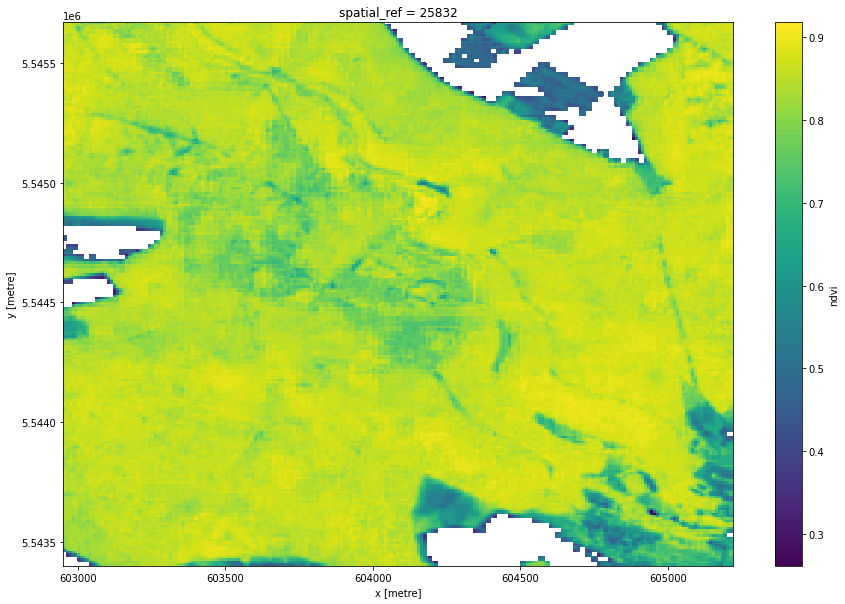

In [78]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.ndvi.plot(size=10) # 
# ...


## Export to cloud optimized geotiff (cog)

Importing needed function from local directories.

In [38]:
from datacube.utils.cog import write_cog

Export for one band:

In [40]:
red_band = median_composite.red

# Write GeoTIFF to a location
write_cog(geo_im=red_band,
          fname='red_median.tif',
          overwrite=True)

PosixPath('red_median.tif')

Export all bands:

In [41]:
rgb_da = median_composite.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='rgb_median.tif',
          # Add a custom folder:
          # fname=
          overwrite=True)

PosixPath('rgb_median.tif')